In [1]:
import networkx as nx
import malaya
import os
import matplotlib.pyplot as plt
from community import community_louvain 
from typing import List
import logging

/home/student/de-prj/de-venv/lib/python3.10/site-packages/malaya/tokenizer.py:214: FutureWarning: Possible nested set at position 3397
  self.tok = re.compile(r'({})'.format('|'.join(pipeline)))
/home/student/de-prj/de-venv/lib/python3.10/site-packages/malaya/tokenizer.py:214: FutureWarning: Possible nested set at position 3927
  self.tok = re.compile(r'({})'.format('|'.join(pipeline)))


In [2]:
logging.basicConfig(level=logging.INFO)
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
# 
synonym_data = {
    "usaha": ["ikhtiar", "kegiatan", "tenggang"],
    "langkah": ["tindakan", "jalan", "cara"],
    "punca": ["asal", "asas", "mula"],
    "kesan": ["akibat", "kebaikan", "efek"],
    "perlu": ["mesti", "wajib"],
    "penting": ["mustahak", "utama"]
}

In [4]:
# Load the malaya semantic similarity model 
model = malaya.similarity.semantic.huggingface()

In [5]:
G = nx.Graph()

# Add relationships
edges_with_weights = []
for word, synonyms in synonym_data.items():
    for synonym in synonyms:
        # Get semantic similarity score of the word and their respective synonym(s) 
        similarity = model.predict_proba([word], [synonym])[0]
        edges_with_weights.append((word, synonym, similarity))
        G.add_edge(word, synonym, weight=similarity)

for edge in G.edges(data=True):
    print(f"Edge: {edge[0]} -> {edge[1]}, Weight: {edge[2]['weight']:.2f}")


You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Edge: usaha -> ikhtiar, Weight: 0.97
Edge: usaha -> kegiatan, Weight: 0.95
Edge: usaha -> tenggang, Weight: 0.10
Edge: langkah -> tindakan, Weight: 0.92
Edge: langkah -> jalan, Weight: 0.92
Edge: langkah -> cara, Weight: 0.83
Edge: punca -> asal, Weight: 0.33
Edge: punca -> asas, Weight: 0.03
Edge: punca -> mula, Weight: 0.15
Edge: kesan -> akibat, Weight: 0.83
Edge: kesan -> kebaikan, Weight: 0.03
Edge: kesan -> efek, Weight: 0.93
Edge: perlu -> mesti, Weight: 0.99
Edge: perlu -> wajib, Weight: 0.94
Edge: penting -> mustahak, Weight: 0.96
Edge: penting -> utama, Weight: 0.99


In [6]:
# Lauvain method : 
# By using the degree of freedom cluster nodes together into a community 
# Steps : 
# 1. The algorithm first assigns each node in the graph to its own community 
#    --> (hav a formula for this, but here we use weight of the edges to find the modularty) 
# 2. Then, it iteratively checks if moving a node to a neighboring community increases the modularity. 
# 3. If so, the node is reassigned to that community.
# 4. All of these will end when the result after iteration is same as b4 iteration 

partition = community_louvain.best_partition(G, weight='weight')

In [7]:
clusters = {}
for word, cluster_id in partition.items():
    clusters.setdefault(cluster_id, []).append(word)

In [8]:
for cluster_id, words in clusters.items():
    print(f"Cluster {cluster_id}: {', '.join(words)}")

Cluster 0: usaha, ikhtiar, kegiatan, tenggang
Cluster 4: langkah, tindakan, jalan, cara
Cluster 2: punca, asal, asas, mula
Cluster 5: kesan, akibat, kebaikan, efek
Cluster 1: perlu, mesti, wajib
Cluster 3: penting, mustahak, utama


In [9]:
# Calc the degree centrality of the nodes, the higher the more central 
centrality = nx.degree_centrality(G)
sorted_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)

In [10]:
# Show the top 6 "centers" with highest degree centrality 
# Why top 6 ? cuz the value changes at the 7th lol will change depends on the output

for word, score in sorted_centrality[:6]:  
    print(f"{word}: {score:.2f}")

usaha: 0.14
langkah: 0.14
punca: 0.14
kesan: 0.14
perlu: 0.10
penting: 0.10


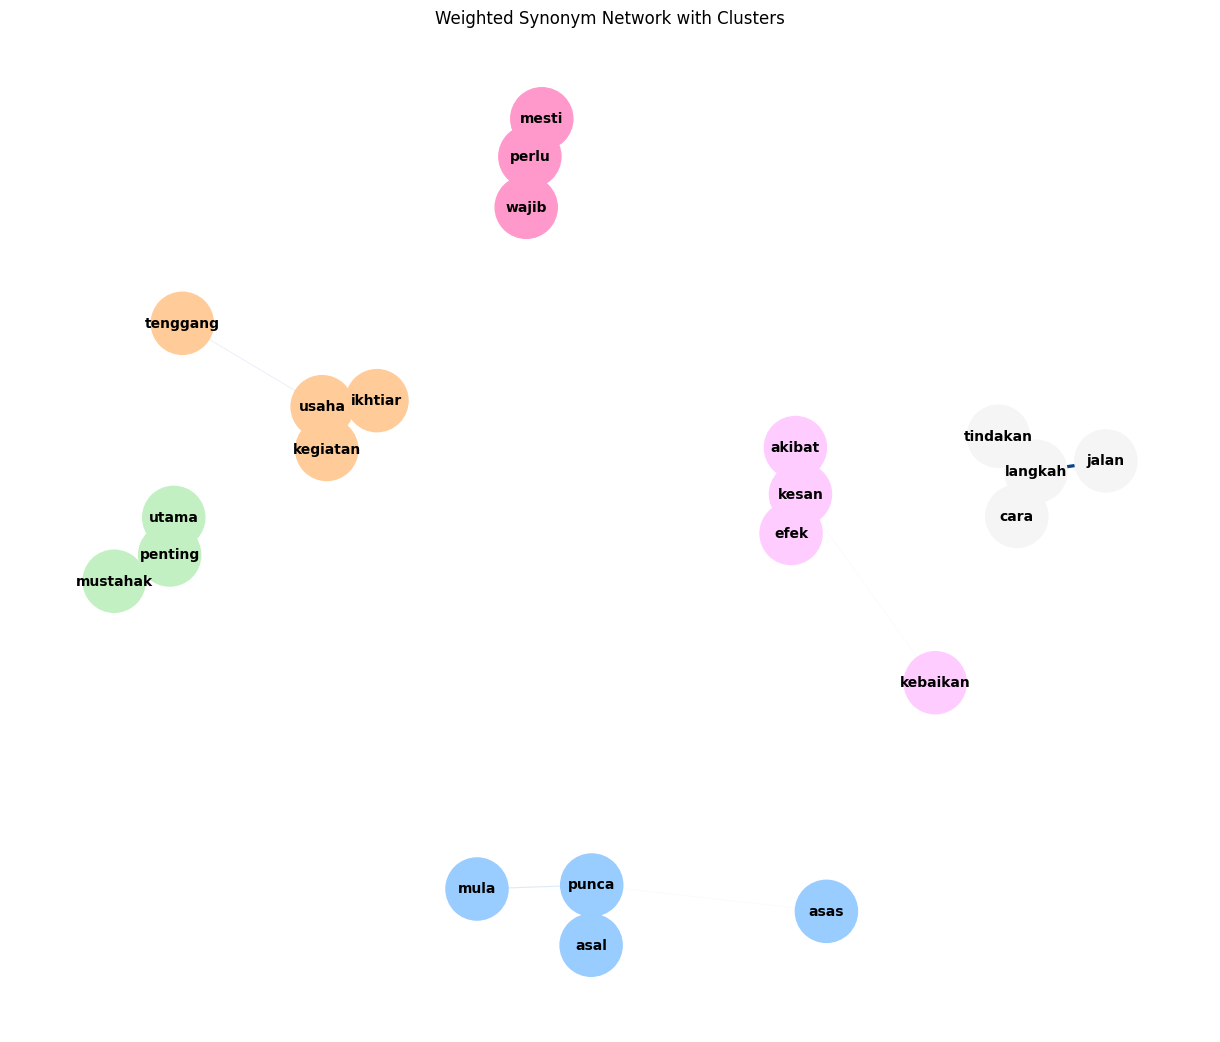

In [11]:
# Visualize the network after clustering 

light_colors = ['#ffcc99', '#ff99cc', '#99ccff', '#c2f0c2', '#f5f5f5', '#ffccff']

colors = [light_colors[partition[node] % len(light_colors)] for node in G.nodes()]

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42)

edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

nx.draw(
    G, pos, with_labels=True, node_color=colors, 
    edge_color=edge_weights, edge_cmap=plt.cm.Blues, 
    width=[0.5 + 2 * w for w in edge_weights], 
    node_size=2000, font_size=10, font_weight="bold"
)

plt.title("Weighted Synonym Network with Clusters")
plt.show()